In [1]:
# coding: utf-8
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_unet.models import custom_unet

SEED = 909
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_TEST = 4
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
NUM_TRAIN = 510
NUM_TEST = 138


def create_train(img_path, mask_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1.0 / 255)
    img_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    img_generator = img_datagen.flow_from_directory(
        img_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        seed=SEED,
    )
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        target_size=IMG_SIZE,
        class_mode=None,
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        seed=SEED,
    )
    return zip(img_generator, mask_generator)


train_img_path = os.path.join("train-output", "images")
train_mask_path = os.path.join("train-output", "masks")

test_mask_path = os.path.join("val-output", "masks")
test_img_path = os.path.join("val-output", "images")

train_generator = create_train(train_img_path, train_mask_path, BATCH_SIZE_TRAIN)
test_generator = create_train(test_img_path, test_mask_path, BATCH_SIZE_TRAIN)

NUM_OF_EPOCHS = 100

Found 1022 images belonging to 1 classes.
Found 1022 images belonging to 1 classes.
Found 445 images belonging to 1 classes.
Found 445 images belonging to 1 classes.


In [2]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(
            tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap="gray"
        )
    plt.show()

In [3]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])

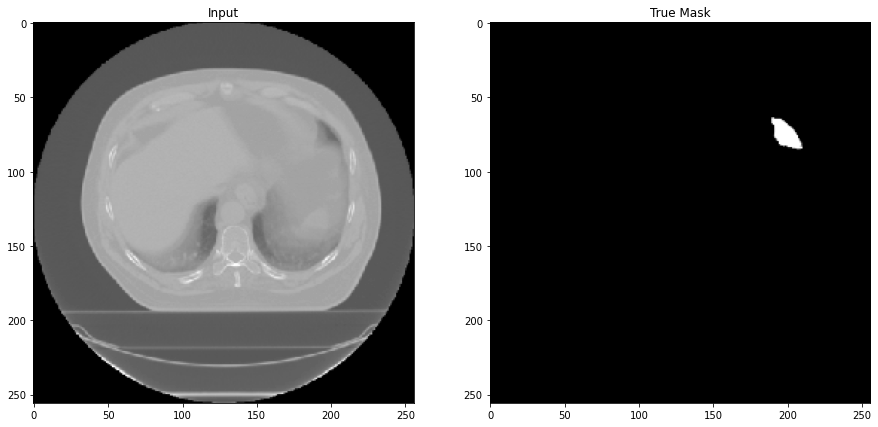

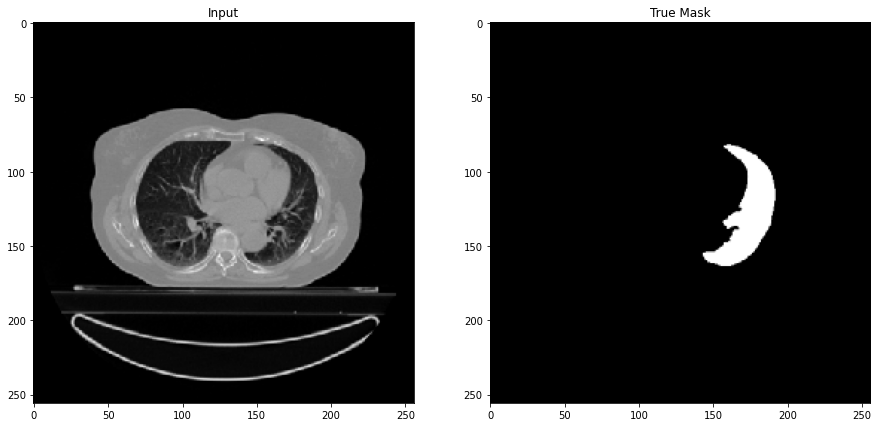

In [4]:
show_dataset(train_generator, 2)

In [27]:
model = custom_unet(
    input_shape=(256, 256, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.25,
    output_activation="sigmoid",
)

In [28]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "binary_accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
    ],
)

In [29]:
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=EPOCH_STEP_TRAIN,
    validation_data=test_generator,
    validation_steps=EPOCH_STEP_TEST,
    epochs=5,
)

Epoch 1/5
127/127 [==============================] - 547s 4s/step - loss: 0.4052 - binary_accuracy: 0.8995 - precision_5: 0.2016 - recall_5: 0.7112 - val_loss: 61.7969 - val_binary_accuracy: 0.6904 - val_precision_5: 0.0686 - val_recall_5: 0.8234
Epoch 2/5
127/127 [==============================] - 553s 4s/step - loss: 0.1042 - binary_accuracy: 0.9858 - precision_5: 0.8445 - recall_5: 0.6712 - val_loss: 0.2819 - val_binary_accuracy: 0.9691 - val_precision_5: 0.4287 - val_recall_5: 0.2693
Epoch 3/5
127/127 [==============================] - 565s 4s/step - loss: 0.0398 - binary_accuracy: 0.9912 - precision_5: 0.9178 - recall_5: 0.8265 - val_loss: 0.0341 - val_binary_accuracy: 0.9914 - val_precision_5: 0.8921 - val_recall_5: 0.7974
Epoch 4/5
127/127 [==============================] - 561s 4s/step - loss: 0.0251 - binary_accuracy: 0.9925 - precision_5: 0.9367 - recall_5: 0.8601 - val_loss: 0.0600 - val_binary_accuracy: 0.9832 - val_precision_5: 0.6425 - val_recall_5: 0.9394
Epoch 5/5
127/1

In [33]:
model.save(f"UNET-A99-P93-R88-{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5")

In [30]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

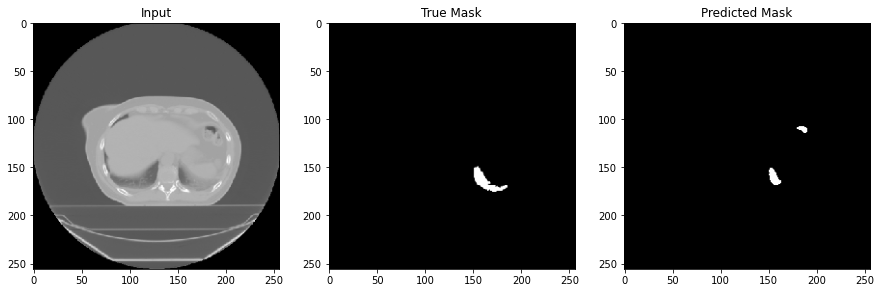

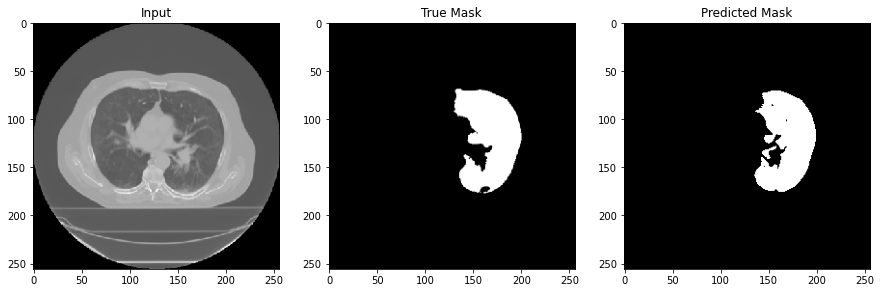

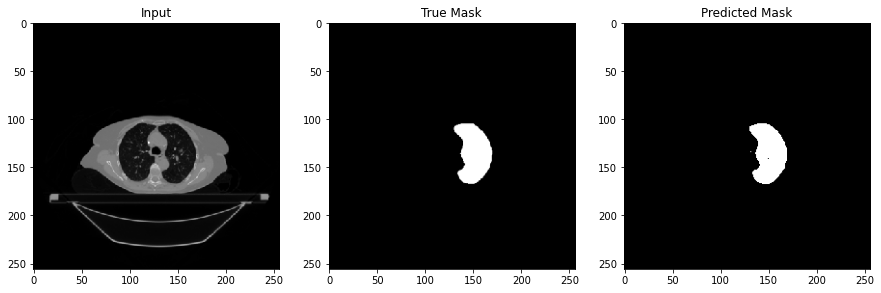

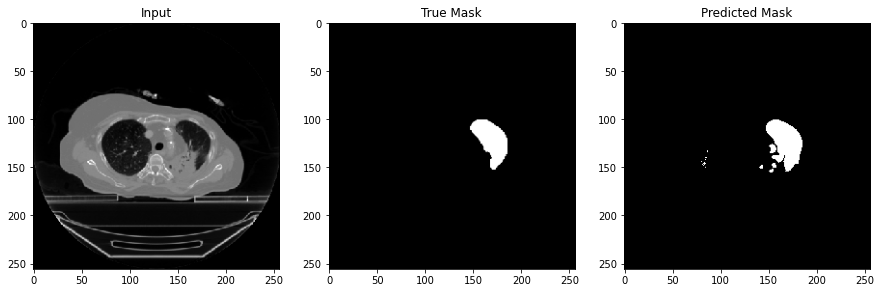

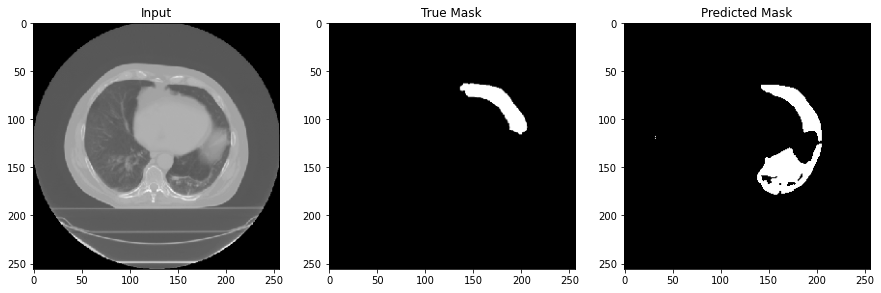

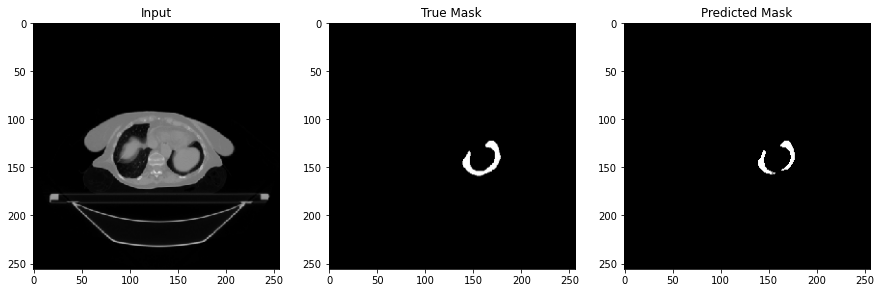

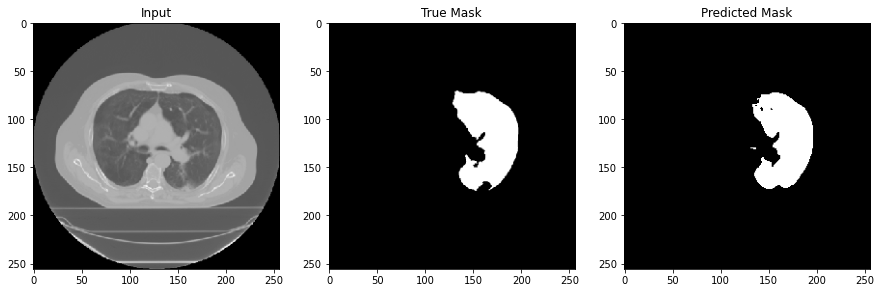

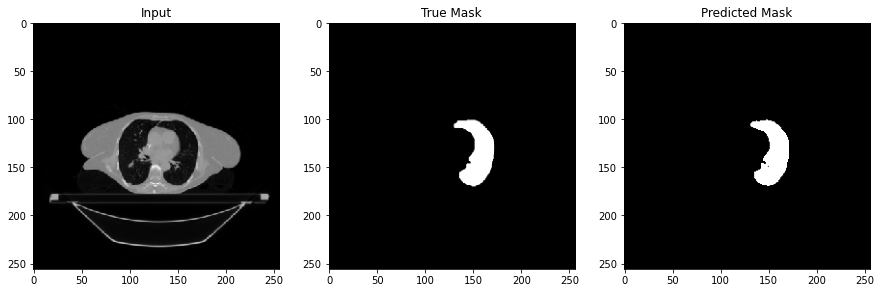

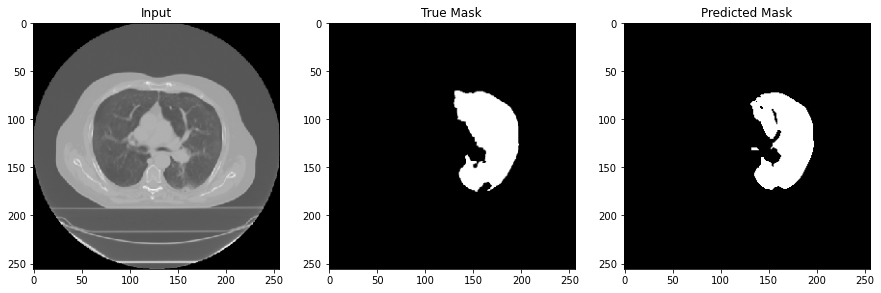

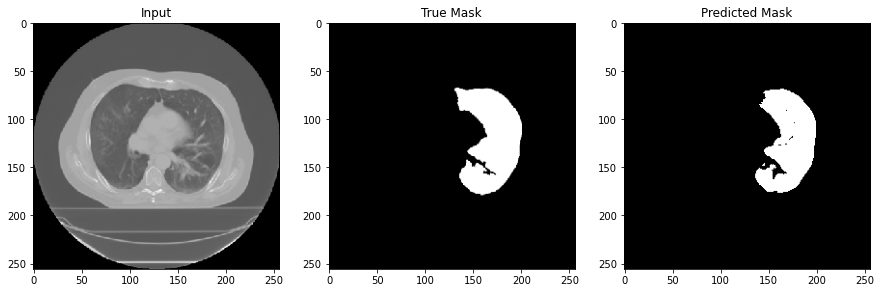

In [34]:
show_prediction(test_generator, 10)